# Graph-Based image segmentation
---

The following code is based on the graph-based segmentation algorithm proposed by Felzenszwalb et. al. ([paper](http://people.cs.uchicago.edu/~pff/papers/seg-ijcv.pdf)).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

In [2]:
image_path = "../img/numbers.jpg"

In [3]:
class DisjointSetForest:
    """ Disjoint-set forest data structure (https://en.wikipedia.org/wiki/Disjoint-set_data_structure).
    Stores a collection of disjoint non-overlapping sets (or a partition of a set into disjoint subsets).
    Provides operations for adding new sets, merging sets (replacing them by their union) and find a 
    representative member of a set. 
    """


    def __init__(self, num_nodes: int):
        """ Disjoint-set forest class constructor.

        Args:
            num_nodes (int): total number of elements to be partitioned.
        """
        self._parent = [i for i in range(num_nodes)]
        self._rank = [0 for i in range(num_nodes)]
        self._size = [1 for i in range(num_nodes)]
        self._num_set = num_nodes



    def find(self, u: int):
        """ Return the representative of a subset.

        Args:
            u (int): node of which we want to know the representative.

        Returns:
            representative of the subset/node.
        """
        if self._parent[u] == u:
            return u

        self._parent[u] = self.find(self._parent[u])
        return self._parent[u]



    def merge(self, u: int, v: int):
        """ Merge two nodes/subsets into one based on their rank.

        Args:
            u (int): first node/subset
            v (int): second node/subset
        """
        u = self.find(u)
        v = self.find(v)

        if u != v:
            if self._rank[u] > self._rank[v]:
                u, v = v, u

            self._parent[u] = v
            self._size[v] += self._size[u]
            if self._rank[u] == self._rank[v]:
                self._rank[v] += 1

            self._num_set -= 1

In [14]:
class ImageGraph:
    """ Graph built by an input image.
    Each pixel is a vertex of G = (V, E) where G is the graph, V is the set of
    vertices and E is the set of edges. Each pixel is connected to its neighbors in
    an 8-grid sense.
    """
    

    def __init__(self, img: str or np.ndarray, preprocessing: bool=True):
        """ ImageGraph class constructor.

        Args:
            img (str or np.ndarray): path to the input image (if preprocessing == True)
                                        or np.ndarray of the input image (already preprocessed)
            preprocessing (bool): (default=True) to be applied if the image has not been preprocessed yet
        """
        if type(img) == str:
            self._img = Image.open(img)
        elif type(img) == np.ndarray:
            self._img = Image.fromarray(img)
        else:
            raise ValueError("Wrong image type: must be either str or np.ndarray.")

        if preprocessing:
            self._processed_img = ImageGraph.preprocessing(self._img)
    


    @staticmethod
    def preprocessing(img: Image, gaussian_blur: bool=True):
        """ Convert an input RGB image to a grayscale Numpy array and applies a Gaussian filter.

        Args:
            img (PIL.Image): image to be processed
            gaussian_blur (bool): (default=True) whether to apply the Gaussian Blur or not
        
        Returns:
            img (np.ndarray): Numpy array represented the processed image
        """
        img = img.convert("L")
        
        if gaussian_blur: 
            img = img.filter(ImageFilter.GaussianBlur(0.8))
        
        return np.array(img)



    def get_diff(self, u_coords: tuple, v_coords: tuple):
        """ Returns the difference in terms of intensity between two pixels of an image.
        
        Args:
            u_coords (tuple): coordinates of first pixel (x1, y1)
            v_coords (tuple): coordinates of second pixel (x2, y2)

        Returns:
            diff (numpy.uint8): difference between the input pixels
        """
        height, width = self._processed_img.shape
        x1, y1 = u_coords
        x2, y2 = v_coords
        
        # necessary check since pixels are uint8 (problem with abs)
        if self._processed_img[y1, x1] > self._processed_img[y2, x2]:
            return self._processed_img[y1, x1] - self._processed_img[y2, x2]
        
        return self._processed_img[y2, x2] - self._processed_img[y1, x1]



    def create_edge(img: np.ndarray, u_coords: tuple, v_coords: tuple):
        """ Creates the edge between two pixels of the input image.

        Args:
            img (numpy.ndarray): input grayscale image in array format (values from 0 to 255)
            u_coords (tuple): coordinates of first pixel (x1, y1)
            v_coords (tuple): coordinates of second pixel (x2, y2)

        Returns:
            id1 (int): first pixel id
            id2 (int): second pixel id
            weight (numpy.uint8): edge weight
        """
        _, width = img.shape
        vertex_id = lambda mytuple: mytuple[1] * width + mytuple[0]

        id1 = vertex_id(u_coords)
        id2 = vertex_id(v_coords)
        weight = get_diff(img, u_coords, v_coords)
        
        return (id1, id2, weight)



    # def build_graph(img: np.ndarray):
    #     """ Build the graph.

    #     Args:
    #         img (numpy.ndarray): input grayscale image in array format (values from 0 to 255)

    #     Returns:
    #         graph (list): list of tuples (u, v, weight) 
    #     """

    #     height, width = img.shape
    #     graph = []

    #     for y in range(height):
    #         for x in range(width):
    #             if x < width - 1:
    #                 U_coords = (x, y)
    #                 v_coords = (x + 1, y)
    #                 graph.append(create_edge(img, u_coords, v_coords))
    #             if y < height - 1:
    #                 U_coords = (x, y)
    #                 v_coords = (x, y + 1)
    #                 graph.append(create_edge(img, u_coords, v_coords))
    #             if x < width - 1 and y < height - 1:
    #                 U_coords = (x, y)
    #                 v_coords = (x + 1, y + 1)
    #                 graph.append(create_edge(img, u_coords, v_coords))
    #             if x < width - 1 and y > 0:
    #                 U_coords = (x, y)
    #                 v_coords = (x + 1, y - 1)
    #                 graph.append(create_edge(img, u_coords, v_coords))

    #     return graph

In [15]:
ig = ImageGraph(image_path)

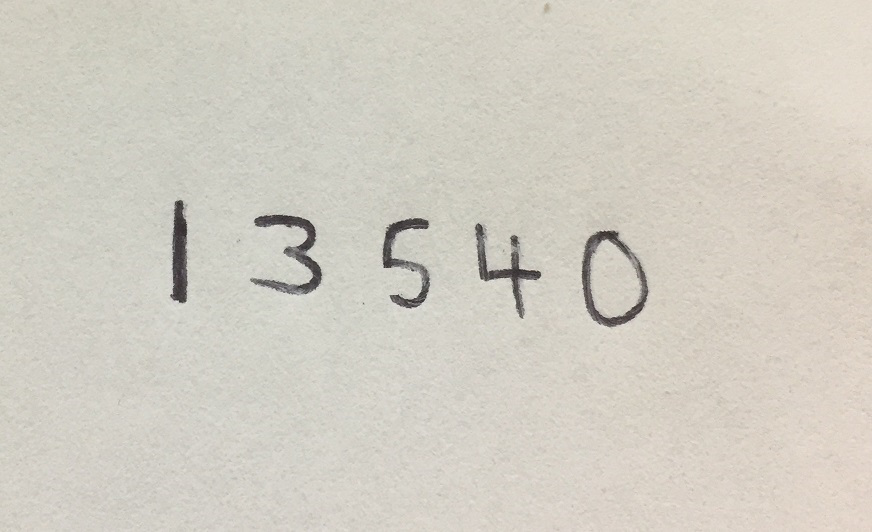

In [16]:
ig._img

In [17]:
ig._processed_img

array([[202, 200, 200, ..., 222, 221, 220],
       [200, 198, 199, ..., 219, 219, 218],
       [199, 196, 198, ..., 218, 218, 219],
       ...,
       [206, 207, 207, ..., 217, 214, 211],
       [209, 206, 204, ..., 216, 214, 212],
       [212, 208, 202, ..., 217, 215, 214]], dtype=uint8)